In [1]:
import torch

checkpoint = torch.load('/content/1D_Advection_Sols_beta0.1_reduced_CNO_75.pt', map_location=torch.device('cpu'))
model_state_dict = checkpoint['model_state_dict']

In [2]:
for name, param in model_state_dict.items():
    print(name, param.shape)

model.lift.inter_CNOBlock.convolution.weight torch.Size([64, 11, 3])
model.lift.inter_CNOBlock.convolution.bias torch.Size([64])
model.lift.inter_CNOBlock.gating.transformer.channel_transform.weight torch.Size([64, 11, 1])
model.lift.inter_CNOBlock.gating.transformer.channel_transform.bias torch.Size([64])
model.lift.inter_CNOBlock.gating.gate_weights.weight torch.Size([64, 64, 3])
model.lift.inter_CNOBlock.gating.gate_weights.bias torch.Size([64])
model.lift.convolution.weight torch.Size([8, 64, 3])
model.lift.convolution.bias torch.Size([8])
model.project.inter_CNOBlock.convolution.weight torch.Size([64, 16, 3])
model.project.inter_CNOBlock.convolution.bias torch.Size([64])
model.project.inter_CNOBlock.gating.transformer.channel_transform.weight torch.Size([64, 11, 1])
model.project.inter_CNOBlock.gating.transformer.channel_transform.bias torch.Size([64])
model.project.inter_CNOBlock.gating.gate_weights.weight torch.Size([64, 64, 3])
model.project.inter_CNOBlock.gating.gate_weights.b

In [3]:
gating_params = {
    name: param for name, param in model_state_dict.items() if '.gating' in name
}

In [4]:
len(gating_params)

220

In [5]:
for name, param in gating_params.items():
    print(f"{name}: {param.shape}")

model.lift.inter_CNOBlock.gating.transformer.channel_transform.weight: torch.Size([64, 11, 1])
model.lift.inter_CNOBlock.gating.transformer.channel_transform.bias: torch.Size([64])
model.lift.inter_CNOBlock.gating.gate_weights.weight: torch.Size([64, 64, 3])
model.lift.inter_CNOBlock.gating.gate_weights.bias: torch.Size([64])
model.project.inter_CNOBlock.gating.transformer.channel_transform.weight: torch.Size([64, 11, 1])
model.project.inter_CNOBlock.gating.transformer.channel_transform.bias: torch.Size([64])
model.project.inter_CNOBlock.gating.gate_weights.weight: torch.Size([64, 64, 3])
model.project.inter_CNOBlock.gating.gate_weights.bias: torch.Size([64])
model.encoder.0.gating.transformer.channel_transform.weight: torch.Size([16, 11, 1])
model.encoder.0.gating.transformer.channel_transform.bias: torch.Size([16])
model.encoder.0.gating.gate_weights.weight: torch.Size([16, 16, 3])
model.encoder.0.gating.gate_weights.bias: torch.Size([16])
model.encoder.1.gating.transformer.channel_t

Channel_transform weights

In [6]:
channel_transform_params = {
    name: param for name, param in gating_params.items() if '.channel_transform.weight' in name
}

In [7]:
len(channel_transform_params)

55

In [8]:
for name, param in channel_transform_params.items():
    print(f"{name}: {param.shape}")

model.lift.inter_CNOBlock.gating.transformer.channel_transform.weight: torch.Size([64, 11, 1])
model.project.inter_CNOBlock.gating.transformer.channel_transform.weight: torch.Size([64, 11, 1])
model.encoder.0.gating.transformer.channel_transform.weight: torch.Size([16, 11, 1])
model.encoder.1.gating.transformer.channel_transform.weight: torch.Size([32, 11, 1])
model.encoder.2.gating.transformer.channel_transform.weight: torch.Size([64, 11, 1])
model.encoder.3.gating.transformer.channel_transform.weight: torch.Size([128, 11, 1])
model.ED_expansion.0.gating.transformer.channel_transform.weight: torch.Size([8, 11, 1])
model.ED_expansion.1.gating.transformer.channel_transform.weight: torch.Size([16, 11, 1])
model.ED_expansion.2.gating.transformer.channel_transform.weight: torch.Size([32, 11, 1])
model.ED_expansion.3.gating.transformer.channel_transform.weight: torch.Size([64, 11, 1])
model.ED_expansion.4.gating.transformer.channel_transform.weight: torch.Size([128, 11, 1])
model.decoder.0.

In [9]:
import torch
import numpy as np
from sklearn.decomposition import PCA

def extract_channel_transform_weights(gating_params):
    all_weight_vectors = []
    all_layer_names = []

    for name, param in gating_params.items():
        if 'channel_transform.weight' in name:
            # param shape: (out_channels, 11, 1)
            weight_matrix = param.squeeze(-1)  # Shape: (out_channels, 11)
            all_weight_vectors.append(weight_matrix)
            all_layer_names.extend([name] * weight_matrix.shape[0])

    # Stack all (out_channels, 11) into one big (N, 11) array
    all_weights_stacked = torch.cat(all_weight_vectors, dim=0).cpu().numpy()
    return all_weights_stacked, all_layer_names

def run_pca_on_weights(weight_matrix, variance_threshold=0.99):
    pca = PCA()
    pca.fit(weight_matrix)

    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.searchsorted(explained_variance_ratio, variance_threshold) + 1

    print(f"Total weight vectors: {weight_matrix.shape[0]}")
    print(f"Input dimension: {weight_matrix.shape[1]}")
    print(f"Explained variance by each PC: {pca.explained_variance_ratio_}")
    print(f"Number of PCs to explain {variance_threshold*100:.0f}% variance: {n_components}")

    return pca, n_components

In [10]:
weights, layer_names = extract_channel_transform_weights(channel_transform_params)

In [11]:
pca_model, num_components = run_pca_on_weights(weights)

Total weight vectors: 2720
Input dimension: 11
Explained variance by each PC: [0.10751617 0.10386549 0.10207797 0.09865943 0.09673405 0.09528853
 0.09141055 0.09034666 0.08637886 0.08086713 0.04685514]
Number of PCs to explain 99% variance: 11


In [12]:
reference_stencils = np.array([
    np.linspace(-5, 5, 11) / 5,  # Central Difference: [-1, 0, 1] scaled for 11 points
    np.linspace(-5, 5, 11) / -5,  # Backward Difference: [-1, 1, 0] scaled for 11 points
    np.linspace(-5, 5, 11) / 5,   # Forward Difference: [0, -1, 1] scaled for 11 points
    np.ones(11) / 11              # Averaging Kernel: [1, 1, 1] / 3 scaled for 11 points
])

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
def plot_pc_as_stencils(pca_components, num_components=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_components):
        plt.subplot(1, num_components, i + 1)
        plt.plot(pca_components[i])
        plt.title(f"PC {i+1}")
        plt.xlabel("Index")
        plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

In [15]:
def project_filters_onto_pcs(filters, pca, num_components=5):
    return pca.transform(filters)[:, :num_components]

# Perform k-means clustering in PCA space
def cluster_in_pca_space(filters, pca, num_clusters=5, num_components=5):
    projected_filters = project_filters_onto_pcs(filters, pca, num_components)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(projected_filters)
    return kmeans.labels_

In [16]:
def compute_cosine_similarity(filters, reference_stencils):
    similarities = []
    for filter_vector in filters:
        sim = cosine_similarity(filter_vector.reshape(1, -1), reference_stencils)
        similarities.append(sim)
    return np.array(similarities)

In [17]:
pca = PCA(n_components=5)  # Or the number of components you want to visualize
pca.fit(weights)

PCA(n_components=5)

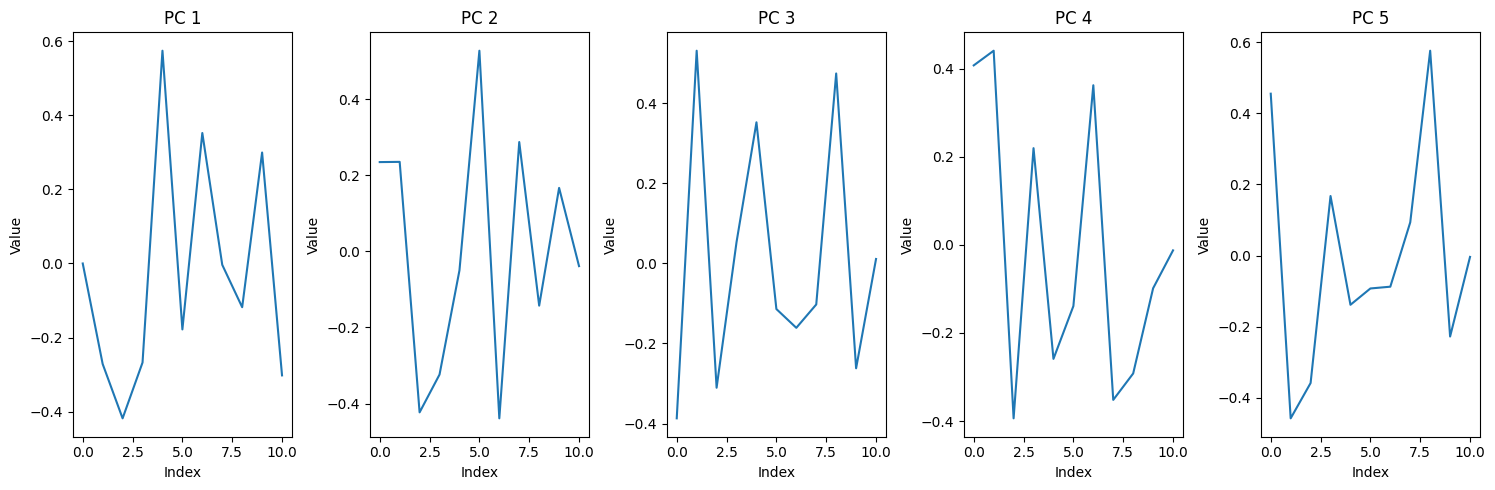

In [18]:
plot_pc_as_stencils(pca.components_, num_components=5)

In [19]:
projected_filters = project_filters_onto_pcs(weights, pca, num_components=5)

In [20]:
cluster_labels = cluster_in_pca_space(weights, pca, num_clusters=5, num_components=5)

In [21]:
similarities = compute_cosine_similarity(weights, reference_stencils)

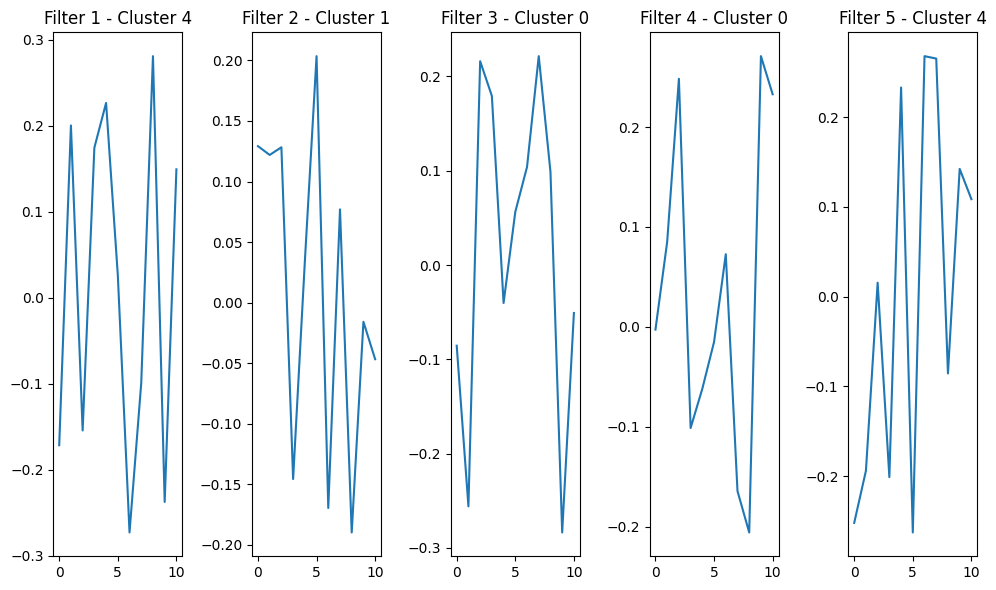

In [22]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(weights[i])
    plt.title(f"Filter {i+1} - Cluster {cluster_labels[i]}")
plt.tight_layout()
plt.show()

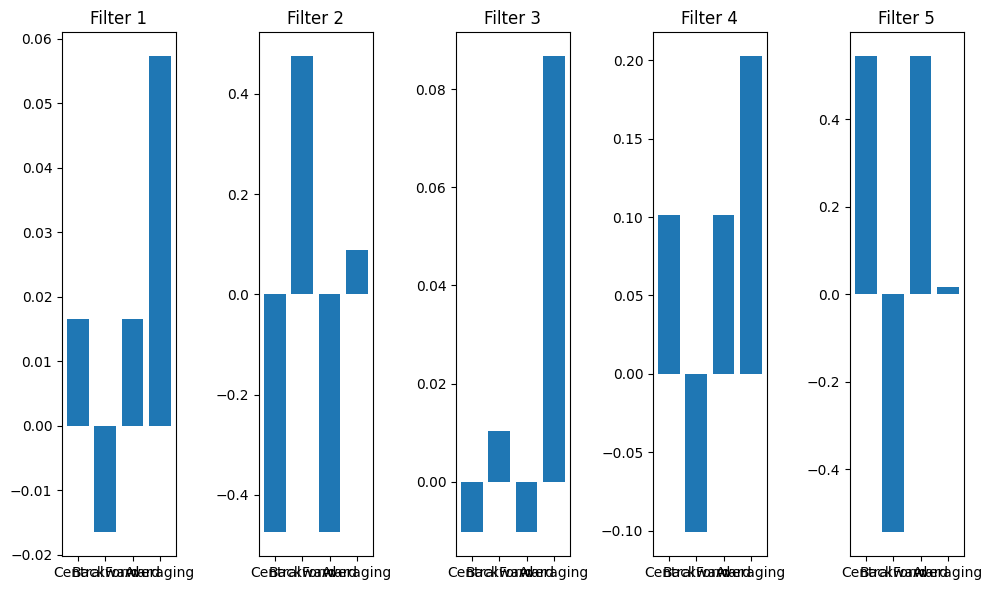

In [23]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.bar(range(4), similarities[i].flatten())
    plt.title(f"Filter {i+1}")
    plt.xticks(range(4), ['Central', 'Backward', 'Forward', 'Averaging'])
plt.tight_layout()
plt.show()

In [24]:
import torch
import torch.nn.functional as F

# Reference 1D stencils, padded to length 11 (centered)
def pad_stencil(s):
    vec = torch.zeros(11)
    mid = 5  # center index
    start = mid - len(s)//2
    vec[start:start+len(s)] = torch.tensor(s, dtype=torch.float32)
    return vec

reference_stencils = {
    'central_diff': pad_stencil([-0.5, 0, 0.5]),
    'backward_diff': pad_stencil([-1, 1, 0]),
    'forward_diff': pad_stencil([0, -1, 1]),
    'average': pad_stencil([1/3, 1/3, 1/3])
}

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# Flatten all weight vectors
all_vectors = weights.reshape(-1, 11)  # shape (2720, 11)

# Compute cosine similarity with each reference stencil
similarity_threshold = 0.75

In [26]:
similarity_counts = {}
for name, ref_vec in reference_stencils.items():
    # Compute cosine similarity with all filters
    sims = cosine_similarity(all_vectors, ref_vec.view(1, -1))
    # Count how many filters exceed threshold
    count = (sims >= similarity_threshold).sum()
    similarity_counts[name] = int(count)

# Show results
for stencil, count in similarity_counts.items():
    print(f"{stencil}: {count} filters with similarity >= {similarity_threshold}")

central_diff: 2 filters with similarity >= 0.75
backward_diff: 3 filters with similarity >= 0.75
forward_diff: 2 filters with similarity >= 0.75
average: 4 filters with similarity >= 0.75


In [27]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

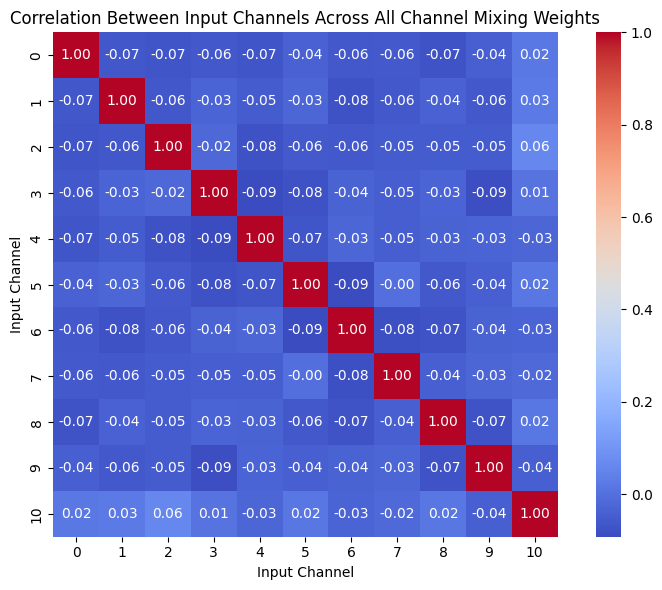

In [28]:
channel_correlation = np.corrcoef(weights.T)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(channel_correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            xticklabels=range(11), yticklabels=range(11))
plt.title("Correlation Between Input Channels Across All Channel Mixing Weights")
plt.xlabel("Input Channel")
plt.ylabel("Input Channel")
plt.tight_layout()
plt.show()

In [29]:
gate_weight_params = {
    name: param for name, param in gating_params.items() if '.gate_weights.weight' in name
}

In [30]:
len(gate_weight_params)

55

In [31]:
for name, param in gate_weight_params.items():
    print(f"{name}: {param.shape}")

model.lift.inter_CNOBlock.gating.gate_weights.weight: torch.Size([64, 64, 3])
model.project.inter_CNOBlock.gating.gate_weights.weight: torch.Size([64, 64, 3])
model.encoder.0.gating.gate_weights.weight: torch.Size([16, 16, 3])
model.encoder.1.gating.gate_weights.weight: torch.Size([32, 32, 3])
model.encoder.2.gating.gate_weights.weight: torch.Size([64, 64, 3])
model.encoder.3.gating.gate_weights.weight: torch.Size([128, 128, 3])
model.ED_expansion.0.gating.gate_weights.weight: torch.Size([8, 8, 3])
model.ED_expansion.1.gating.gate_weights.weight: torch.Size([16, 16, 3])
model.ED_expansion.2.gating.gate_weights.weight: torch.Size([32, 32, 3])
model.ED_expansion.3.gating.gate_weights.weight: torch.Size([64, 64, 3])
model.ED_expansion.4.gating.gate_weights.weight: torch.Size([128, 128, 3])
model.decoder.0.gating.gate_weights.weight: torch.Size([64, 64, 3])
model.decoder.1.gating.gate_weights.weight: torch.Size([32, 32, 3])
model.decoder.2.gating.gate_weights.weight: torch.Size([16, 16, 3]

In [36]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# ---- STEP 1: Stack and normalize all gate weights ----
def extract_gate_filters(model_state_dict):
    gate_filters = []
    for name, param in model_state_dict.items():
        if 'gate_weights.weight' in name and param.ndim == 3:
            weight = param.cpu().numpy()  # shape: [C_out, C_in, 3]
            filters = weight.reshape(-1, 3)  # Flatten to [N, 3]
            gate_filters.append(filters)
    print(len(gate_filters))
    all_filters = np.concatenate(gate_filters, axis=0)
    # Normalize to unit norm
    norms = np.linalg.norm(all_filters, axis=1, keepdims=True)
    normalized = all_filters / (norms + 1e-8)
    return normalized

# Example usage:
# normalized_filters = extract_gate_filters(model.state_dict())

# ---- STEP 2: PCA projection and visualization ----
def plot_pca_scatter(filters, n_components=2):
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(filters)
    plt.figure(figsize=(6, 5))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.4, s=5)
    plt.title('PCA of Gate Filters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()
    return reduced, pca

# ---- STEP 3: K-Means clustering and visualization ----
def cluster_and_plot(filters, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(filters)
    cluster_centers = kmeans.cluster_centers_

    plt.figure(figsize=(6, 5))
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(filters)
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=5, alpha=0.6)
    plt.title('K-Means Clustering of Gate Filters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()

    print("Cluster Centers (normalized):")
    for i, center in enumerate(cluster_centers):
        print(f"Cluster {i}: {np.round(center, 3)}")
    return cluster_centers

# ---- STEP 4: Compare with known stencil filters ----
def compare_with_reference_stencils(filters, threshold=0.8):
    # Define reference stencils
    reference_filters = {
        "central_diff": np.array([-1, 0, 1]),
        "backward_diff": np.array([1, -1, 0]),
        "forward_diff": np.array([0, -1, 1]),
        "upward_diff": np.array([1, 0, -1]),
        "downward_diff": np.array([-1, 0, 1]),
        "average": np.array([0.5, 0.5, 0]),
        "symmetric_avg": np.array([0.5, 0, 0.5]),
    }

    # Normalize references
    for k in reference_filters:
        reference_filters[k] = reference_filters[k] / (np.linalg.norm(reference_filters[k]) + 1e-8)

    similarities = {}
    for name, ref in reference_filters.items():
        sim = cosine_similarity(filters, ref.reshape(1, -1)).flatten()
        mask = sim >= threshold
        count = np.sum(mask)
        max_sim = np.round(np.max(sim), 3)
        avg_sim = np.round(np.mean(sim[mask]), 3) if count > 0 else 0.0
        similarities[name] = (count, max_sim, avg_sim)

    print(f"Stencil similarity counts (threshold ≥ {threshold}):")
    for name, (count, max_sim, avg_sim) in similarities.items():
        print(f"{name}: {count} filters matched, max = {max_sim}, avg = {avg_sim}")

    return similarities

In [33]:
filters = extract_gate_filters(model_state_dict)

55


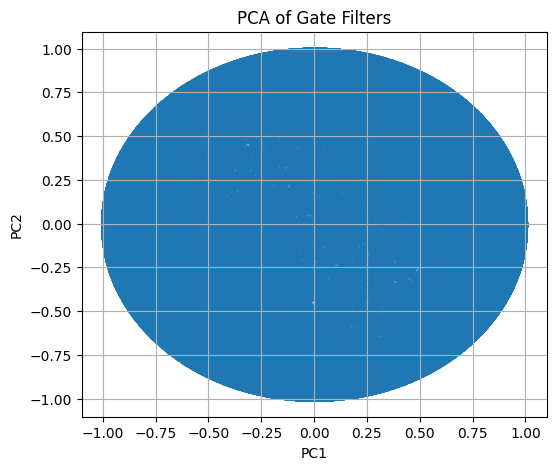

(array([[ 0.24297294,  0.8945119 ],
        [ 0.19687717, -0.9682298 ],
        [-0.32330143,  0.94143593],
        ...,
        [-0.6882724 , -0.16121872],
        [-0.386663  , -0.88192487],
        [-0.24178447,  0.20574923]], dtype=float32),
 PCA(n_components=2))

In [34]:
plot_pca_scatter(filters)

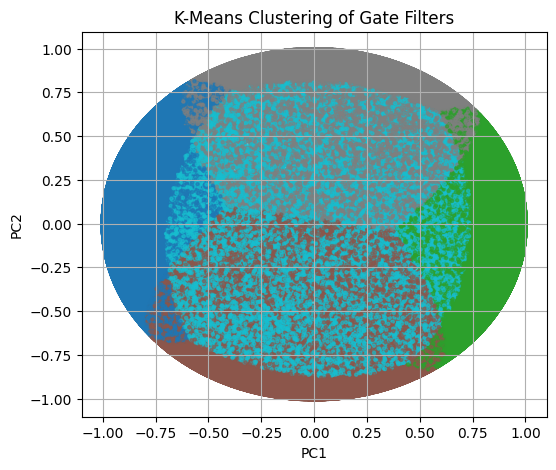

Cluster Centers (normalized):
Cluster 0: [-0.432 -0.497 -0.541]
Cluster 1: [0.449 0.477 0.55 ]
Cluster 2: [ 0.49   0.126 -0.59 ]
Cluster 3: [-0.007 -0.539  0.559]
Cluster 4: [-0.58   0.526  0.033]


In [35]:
cluster_centers = cluster_and_plot(filters, n_clusters=5)

In [37]:
filters.shape

(231808, 3)

In [38]:
compare_with_reference_stencils(filters, threshold=0.8)

Stencil similarity counts (threshold ≥ 0.8):
central_diff: 19306 filters matched, max = 1.0, avg = 0.897
backward_diff: 17151 filters matched, max = 1.0, avg = 0.898
forward_diff: 20058 filters matched, max = 1.0, avg = 0.899
upward_diff: 18758 filters matched, max = 1.0, avg = 0.897
downward_diff: 19306 filters matched, max = 1.0, avg = 0.897
average: 26733 filters matched, max = 1.0, avg = 0.9
symmetric_avg: 28998 filters matched, max = 1.0, avg = 0.897


{'central_diff': (np.int64(19306), np.float64(1.0), np.float64(0.897)),
 'backward_diff': (np.int64(17151), np.float64(1.0), np.float64(0.898)),
 'forward_diff': (np.int64(20058), np.float64(1.0), np.float64(0.899)),
 'upward_diff': (np.int64(18758), np.float64(1.0), np.float64(0.897)),
 'downward_diff': (np.int64(19306), np.float64(1.0), np.float64(0.897)),
 'average': (np.int64(26733), np.float64(1.0), np.float64(0.9)),
 'symmetric_avg': (np.int64(28998), np.float64(1.0), np.float64(0.897))}

In [ ]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Reference filters (stencil kernels)
reference_filters = {
    "central_diff": np.array([-1, 0, 1]),
    "backward_diff": np.array([1, -1, 0]),
    "forward_diff": np.array([0, -1, 1]),
    "upward_diff": np.array([1, 0, -1]),
    "downward_diff": np.array([-1, 0, 1]),
    "average": np.array([0.5, 0.5, 0]),
    "symmetric_avg": np.array([0.5, 0, 0.5]),
}

# Normalize reference filters
for k in reference_filters:
      reference_filters[k] = reference_filters[k] / (np.linalg.norm(reference_filters[k]) + 1e-8)

# Simulate loading a model state_dict
dummy_state_dict = {}

In [ ]:
# Utility function for analyzing a single gate tensor
def analyze_gate_tensor(tensor: torch.Tensor, threshold=0.8):
    weight = tensor.cpu().numpy()
    filters = weight.reshape(-1, 3)
    norms = np.linalg.norm(filters, axis=1, keepdims=True)
    filters_normalized = filters / (norms + 1e-8)

    result = {}
    for name, ref in reference_filters.items():
        sim = cosine_similarity(filters_normalized, ref.reshape(1, -1)).flatten()
        over_thresh = sim >= threshold
        count = np.sum(over_thresh)
        avg_sim = np.mean(sim[over_thresh]) if count > 0 else 0.0
        max_sim = np.max(sim[over_thresh]) if count > 0 else 0.0
        result[name] = {
            "count": int(count),
            "avg_sim": float(np.round(avg_sim, 4)),
            "max_sim": float(np.round(max_sim, 4))
        }
    return result

In [ ]:
def organize_by_module(state_dict):
    module_dict = {
        "lift": [],
        "project": [],
        "encoder": [[], [], [], []],
        "ED_expansion": [[], [], [], [], []],
        "decoder": [[], [], [], []],
        "res_nets": [[], [], [], []],  # each has 4 residual blocks with 2 gates
        "res_net_neck": [[], [], [], []]  # each has 2 gates
    }
    for name, param in state_dict.items():
        if "gate_weights.weight" not in name:
            continue
        if name.startswith("model.lift"):
            module_dict["lift"].append((name, param))
        elif name.startswith("model.project"):
            module_dict["project"].append((name, param))
        elif name.startswith("model.encoder"):
            idx = int(name.split(".")[2])
            module_dict["encoder"][idx].append((name, param))
        elif name.startswith("model.ED_expansion"):
            idx = int(name.split(".")[2])
            module_dict["ED_expansion"][idx].append((name, param))
        elif name.startswith("model.decoder"):
            idx = int(name.split(".")[2])
            module_dict["decoder"][idx].append((name, param))
        elif name.startswith("model.res_nets"):
            resnet_idx = int(name.split(".")[2])
            module_dict["res_nets"][resnet_idx].append((name, param))
        elif name.startswith("model.res_net_neck"):
            block_idx = int(name.split(".")[3])
            module_dict["res_net_neck"][block_idx].append((name, param))
    return module_dict

In [ ]:
organized = organize_by_module(model_state_dict)

In [ ]:
organized

{'lift': [('model.lift.inter_CNOBlock.gating.gate_weights.weight',
   tensor([[[ 0.0572,  0.0459, -0.0499],
            [-0.0182,  0.0492, -0.0582],
            [-0.0096, -0.0561, -0.0578],
            ...,
            [ 0.0185, -0.0300, -0.0627],
            [ 0.0404, -0.0364,  0.0533],
            [ 0.0484,  0.0156,  0.0472]],
   
           [[-0.0366, -0.0322,  0.0627],
            [-0.0511, -0.0067,  0.0427],
            [-0.0388,  0.0507, -0.0072],
            ...,
            [ 0.0277,  0.0415, -0.0363],
            [-0.0610, -0.0022, -0.0140],
            [ 0.0232,  0.0573, -0.0002]],
   
           [[-0.0533,  0.0232,  0.0155],
            [-0.0569, -0.0229,  0.0154],
            [ 0.0245,  0.0687,  0.0221],
            ...,
            [-0.0456, -0.0574,  0.0672],
            [ 0.0340,  0.0382, -0.0394],
            [ 0.0497,  0.0817,  0.0477]],
   
           ...,
   
           [[ 0.0652, -0.0500, -0.0016],
            [ 0.0557, -0.0179,  0.0201],
            [ 0.0711, -0.03

In [ ]:
# Run this logic after loading the actual model state_dict

for module, blocks in organized.items():
    if isinstance(blocks[0], tuple):  # single block like lift, project
        for name, param in blocks:
            print(f"\n{module.upper()} - {name}")
            result = analyze_gate_tensor(param)
            print(result)
    else:  # list of layers/blocks
        for i, layer in enumerate(blocks):
            print(f"\n{module.upper()} Layer {i}")
            for name, param in layer:
                print(f"  {name}")
                result = analyze_gate_tensor(param)
                print(result)




LIFT - model.lift.inter_CNOBlock.gating.gate_weights.weight
{'central_diff': {'count': 378, 'avg_sim': 0.8994, 'max_sim': 0.9999}, 'backward_diff': {'count': 410, 'avg_sim': 0.9027, 'max_sim': 0.9996}, 'forward_diff': {'count': 421, 'avg_sim': 0.9007, 'max_sim': 0.9984}, 'upward_diff': {'count': 401, 'avg_sim': 0.8961, 'max_sim': 0.9996}, 'downward_diff': {'count': 378, 'avg_sim': 0.8994, 'max_sim': 0.9999}, 'average': {'count': 462, 'avg_sim': 0.9049, 'max_sim': 1.0}, 'symmetric_avg': {'count': 431, 'avg_sim': 0.9029, 'max_sim': 0.9995}}

PROJECT - model.project.inter_CNOBlock.gating.gate_weights.weight
{'central_diff': {'count': 372, 'avg_sim': 0.8981, 'max_sim': 0.9996}, 'backward_diff': {'count': 336, 'avg_sim': 0.9062, 'max_sim': 0.9994}, 'forward_diff': {'count': 335, 'avg_sim': 0.8959, 'max_sim': 0.9986}, 'upward_diff': {'count': 382, 'avg_sim': 0.9032, 'max_sim': 0.9993}, 'downward_diff': {'count': 372, 'avg_sim': 0.8981, 'max_sim': 0.9996}, 'average': {'count': 457, 'avg_sim'

In [ ]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from pathlib import Path

In [ ]:
def normalize(v): return v / v.norm(p=2)

In [ ]:
known_filters = {
    "central_diff": normalize(torch.tensor([-0.5, 0.0, 0.5])),
    "backward_diff": normalize(torch.tensor([1.0, -1.0, 0.0])),
    "forward_diff": normalize(torch.tensor([0.0, -1.0, 1.0])),
    "upward_diff": normalize(torch.tensor([1.0, 0.0, -1.0])),
    "downward_diff": normalize(torch.tensor([-1.0, 0.0, 1.0])),
    "average": normalize(torch.tensor([1.0, 1.0, 1.0])),
    "symmetric_avg": normalize(torch.tensor([0.5, 1.0, 0.5])),
}

# === Config ===
SIM_THRESHOLD = 0.8

In [ ]:
ckpt = torch.load("/content/1D_Advection_Sols_beta0.1_reduced_CNO.pt", map_location="cpu")  # <- Update path
model_dict = ckpt['model_state_dict']

In [ ]:
grouped_weights = defaultdict(list)

for key, weight in model_dict.items():
    if not key.endswith("gate_weights.weight") or weight.ndim != 3:
        continue
    if weight.shape[-1] != 3:
        continue

    parts = key.split('.')
    # Handle res_nets.n.res_blocks.m.gatingX.gate_weights.weight
    if "res_blocks" in parts:
        block_idx = parts.index("res_blocks")
        block_name = '.'.join(parts[:block_idx + 2])  # e.g. res_nets.0.res_blocks.0
    elif "encoder" in parts or "decoder" in parts or "ED_expansion" in parts:
        block_name = '.'.join(parts[:2])  # e.g. encoder.0
    else:
        block_name = '.'.join(parts[:-2])  # e.g. lift.inter_CNOBlock.gating

    grouped_weights[block_name].append((key, weight))

In [ ]:
def compute_similarities(filter_vecs, filter_name, known_filter):
    sims = F.cosine_similarity(filter_vecs, known_filter.view(1, -1), dim=1)
    matched = sims >= SIM_THRESHOLD
    if matched.sum() == 0:
        return 0, 0.0, 0.0
    return matched.sum().item(), sims[matched].max().item(), sims[matched].mean().item()

print(f"\nThreshold for similarity: {SIM_THRESHOLD}\n")


Threshold for similarity: 0.8



In [ ]:
for block_name in sorted(grouped_weights.keys()):
    print(f"\n==== Block: {block_name} ====")
    for tensor_name, tensor in grouped_weights[block_name]:
        C_out, C_in, K = tensor.shape
        filter_vecs = tensor.view(-1, K)
        num_filters = filter_vecs.size(0)
        print(f"\nLayer: {tensor_name}")
        print(f"Total filters: {num_filters}")

        for name, kf in known_filters.items():
            matched_count, max_sim, avg_sim = compute_similarities(filter_vecs, name, kf)
            matched_count = matched_count / num_filters
            print(f"  {name:15}: {matched_count:5} filters matched, "
                  f"max sim = {max_sim:.3f}, avg sim = {avg_sim:.3f}")


==== Block: model.ED_expansion ====

Layer: model.ED_expansion.0.gating.gate_weights.weight
Total filters: 64
  central_diff   : 0.09375 filters matched, max sim = 0.901, avg sim = 0.865
  backward_diff  : 0.09375 filters matched, max sim = 0.968, avg sim = 0.928
  forward_diff   : 0.140625 filters matched, max sim = 0.966, avg sim = 0.906
  upward_diff    : 0.140625 filters matched, max sim = 0.982, avg sim = 0.916
  downward_diff  : 0.09375 filters matched, max sim = 0.901, avg sim = 0.865
  average        : 0.0625 filters matched, max sim = 0.937, avg sim = 0.898
  symmetric_avg  : 0.109375 filters matched, max sim = 0.989, avg sim = 0.880

Layer: model.ED_expansion.1.gating.gate_weights.weight
Total filters: 256
  central_diff   : 0.125 filters matched, max sim = 0.995, avg sim = 0.901
  backward_diff  : 0.09765625 filters matched, max sim = 0.990, avg sim = 0.889
  forward_diff   : 0.1015625 filters matched, max sim = 0.994, avg sim = 0.911
  upward_diff    : 0.08984375 filters m